# Parameter estimation in ESG module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import pickle

Index

In [2]:
index_df = pd.read_csv('./data/index.csv',index_col='price_date')

In [3]:
index_df.head()

,ALTERNATIVE,CPI,EQ_SWE,EQ_WORLD,IR_1,IR_15,IR_5,PROPERTY,SPREAD
price_date,,,,,,,,,
2003-12-31,100.000000,278.0,224.48,4041.233665,0.029400,0.048920,0.03988,100.40,0.00379
2004-01-30,100.812146,277.3,238.87,4241.075265,0.027374,0.048141,0.04050,100.90,0.00400
2004-02-27,101.725526,279.4,250.56,4341.993088,0.025854,0.046236,0.03755,101.40,0.00270
2004-03-31,102.640223,279.4,248.29,4375.960151,0.022710,0.046868,0.03415,101.91,0.00290
2004-04-30,101.088818,280.1,251.56,4331.790677,0.024333,0.049752,0.03875,102.41,0.00320


In [4]:
stocks = ['EQ_SWE', 'EQ_WORLD', 'ALTERNATIVE', 'CPI', 'PROPERTY']
rates = ['IR_1', 'IR_5', 'IR_15', 'SPREAD']

<Axes: xlabel='price_date'>

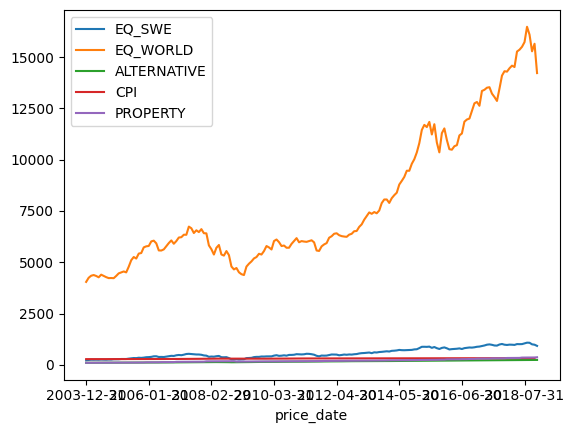

In [5]:
index_df[stocks].plot()

<Axes: xlabel='price_date'>

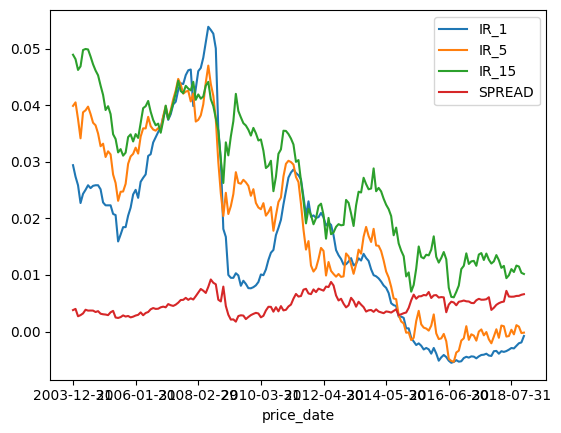

In [6]:
index_df[rates].plot()

In [7]:
returns_df = np.log(index_df[stocks]).diff()[1:]
returns_df[rates] = index_df[rates].diff()[1:]

In [8]:
returns_df.head()

,EQ_SWE,EQ_WORLD,ALTERNATIVE,CPI,PROPERTY,IR_1,IR_5,IR_15,SPREAD
price_date,,,,,,,,,
2004-01-30,0.062133,0.048267,0.008089,-0.002521,0.004968,-0.002026,0.00062,-0.000779,0.00021
2004-02-27,0.047779,0.023517,0.009019,0.007544,0.004943,-0.001520,-0.00295,-0.001905,-0.00130
2004-03-31,-0.009101,0.007792,0.008952,0.000000,0.005017,-0.003144,-0.00340,0.000632,0.00020
2004-04-30,0.013084,-0.010145,-0.015230,0.002502,0.004894,0.001623,0.00460,0.002884,0.00030
2004-05-31,-0.012319,-0.015384,-0.001586,-0.004293,0.004870,0.000710,0.00035,0.000187,0.00065


### Estimating $\mu$ and $\sigma$ for stocks

In [9]:
variance = returns_df[stocks].var()*12 # 12 months
mean = returns_df[stocks].mean()*12
ar = returns_df[stocks].mean()*0 

### Estimating a, $\mu$ and $\sigma$ for rates

O-U has analytic solution

$r(t) = r_0 e^{-at} + \mu (1 - e^{-at}) + \sigma \int_0^t e^{a(s-t)}dB(s)$

which is discretized

$r_{t+1} = r_t e^{-a\Delta t} + \mu (1 - e^{-a\Delta t}) +
\sigma \sqrt{\frac{1 - e^{-2a\Delta t}}{2a}} \Delta B$

to map coefficients from linear regression

$r_{t+1} = w_1 r_t + w_0 + \epsilon$

In [10]:
reg = linear_model.LinearRegression()

In [11]:
d = 1/12 # months
for rate in index_df[rates]:
    y = index_df[rate][1:].to_numpy()
    X = index_df[rate][:-1].to_numpy().reshape(-1,1)
    reg.fit(X,y)
    w0 = reg.intercept_
    w1 = reg.coef_[0]
    sd = np.sqrt(mean_squared_error(w0 + w1*X, y))
    
    a = -np.log(w1)/d
    mu = w0/(1-w1)
    sigma = sd * np.sqrt(-2*np.log(w1)/(d*(1-w1**2)))
    
    variance[rate] = sigma**2
    mean[rate] = mu
    ar[rate] = a

### Initial values and correlation from observations

In [12]:
s0 = index_df[stocks+rates].iloc[0]
Corr = returns_df.corr()

Simulation parameters

In [13]:
params = (s0, Corr, variance, mean, ar)

In [14]:
with open('./data/params.pkl', 'wb') as f:
    pickle.dump(params, f)